# Multi-parameter, multi-object calibration
In this notebook I take a first look at the results of the multi-parameter, multi-object calibration.

**Multi-parameter**, **Mulit-object** you ask?! Let me exlpain... For the glacier model to work correctly (or at least as best as possible) a thorough calibration is necessary. There are three tuning paramaters which I use, the (hypothetical) equilibrium year ($t^*$, `t_star`), the precipitation scaling factor (`prcp_scaling_factor`) and the sliding parameter, also known as Glen's A parametere (`glen_a`). Hence, *multi-parameter*.
The model output is validated against historic glacier length (change) records. The model *skill* is reflected in the correlation coefficient as well as the root mean squared deviation. We seek a result with an optimal combination of both skill scores (i.e., high correlation coeffiecietn and low RMDS), hence *multi-object*.

The findings are written up in `../text/`

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read created Dataset
path = '../data/glen_a.nc'
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:     (glen_a_fac: 5, prcp_fac: 4, t_star: 6)
Coordinates:
  * t_star      (t_star) int64 1935 1940 1945 1950 1955 1960
  * prcp_fac    (prcp_fac) float64 1.0 1.25 1.5 1.75
  * glen_a_fac  (glen_a_fac) float64 0.1 0.5 1.0 2.0 10.0
Data variables:
    corr        (glen_a_fac, prcp_fac, t_star) float64 ...
    rmsd        (glen_a_fac, prcp_fac, t_star) float64 ...
    rmsd_bc     (glen_a_fac, prcp_fac, t_star) float64 ...
    amp_diff    (glen_a_fac, prcp_fac, t_star) float64 ...

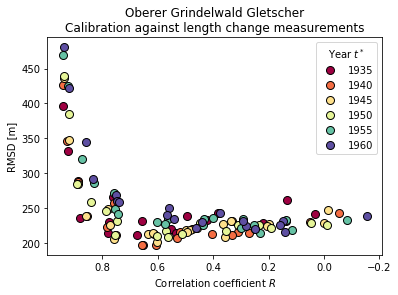

In [29]:
# create empty container
corr_x = list()
rmsd_y = list()

cmap = matplotlib.cm.get_cmap('Spectral', ds.t_star.size)
for i, t_star in enumerate(ds.t_star.values):
    # get x and y values for given year
    x = ds.corr.sel(t_star=t_star)
    y = ds.rmsd.sel(t_star=t_star)
    # add x and y values to container
    corr_x.append(x.values.flatten())
    rmsd_y.append(y.values.flatten())
    plt.plot(x,y, ls='None', marker='o', color=cmap(i),
             markeredgecolor='k', markersize=8, label=t_star)
        
# get figure axes
ax = plt.gca()
ax.invert_xaxis()
# legend
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[::4], ds.t_star.values, title='Year $t^*$')
# labels, title
ax.set_xlabel('Correlation coefficient $R$')
ax.set_ylabel('RMSD [m]')
ax.set_title('Oberer Grindelwald Gletscher\n' + 'Calibration against length change measurements');

path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/calibration.pdf'
plt.savefig(path, bbox_inches='tight')

In [30]:
def func(x, a, b, c):
    """Exponential function to bit fitted to data points"""
    return a * np.exp(b * x) + c

# make sure x and y data is 1D array
corr_x = np.array(corr_x).flatten()
rmsd_y = np.array(rmsd_y).flatten()
# fit curve
[a, b, c], _ = curve_fit(func, corr_x, rmsd_y)

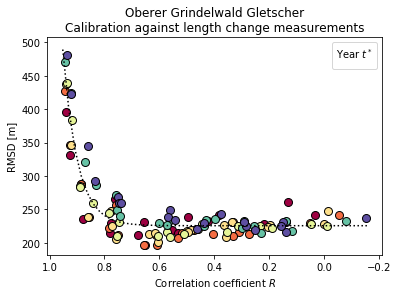

In [31]:
cmap = matplotlib.cm.get_cmap('Spectral', ds.t_star.size)
for i, t_star in enumerate(ds.t_star.values):
    # get x and y values for given year
    x = ds.corr.sel(t_star=t_star)
    y = ds.rmsd.sel(t_star=t_star)
    plt.plot(x,y, ls='None', marker='o', color=cmap(i),
             markeredgecolor='k', markersize=8, label=t_star)
    
# add fitted curve
x = np.linspace(min(corr_x)*1.01, max(corr_x)*1.01)
y = func(x, a, b, c)
plt.plot(x, y, ls=':', c='k')
        
# get figure axes
ax = plt.gca()
ax.invert_xaxis()
# legend
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[::4], ds.t_star.values, title='Year $t^*$')
# labels, title
ax.set_xlabel('Correlation coefficient $R$')
ax.set_ylabel('RMSD [m]')
ax.set_title('Oberer Grindelwald Gletscher\n' + 'Calibration against length change measurements');

path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/calibration.pdf'
plt.savefig(path, bbox_inches='tight')

## Select a subset of parameter trios
Now I'd like to know which combination of parameters produce the "best" results.

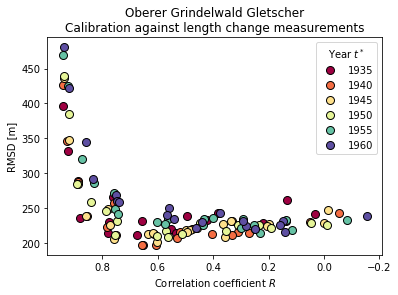

In [33]:
cmap = matplotlib.cm.get_cmap('Spectral', ds.t_star.size)
for i, t_star in enumerate(ds.t_star.values):
    x = ds.corr.sel(t_star=t_star)
    y = ds.rmsd.sel(t_star=t_star)
    plt.plot(x,y, ls='None', marker='o', color=cmap(i),
             markeredgecolor='k', markersize=8, label=t_star)
    
# get figure axes
ax = plt.gca()
ax.invert_xaxis()
# legend
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[::4], ds.t_star.values, title='Year $t^*$')
# labels, title
ax.set_xlabel('Correlation coefficient $R$')
ax.set_ylabel('RMSD [m]')
ax.set_title('Oberer Grindelwald Gletscher\n' + 'Calibration against length change measurements');

path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/calibration.pdf'
plt.savefig(path, bbox_inches='tight')

First, lets narrow the view to parameters which results in an RMSD below 300 m and a correlation coefficient above 0.75.

In [34]:
# define thresholds
corr_threshold = 0.75
rmsd_threshold = 300

In [35]:
ds_select = ds.where((ds.corr > corr_threshold) & (ds.rmsd < rmsd_threshold), drop=True)

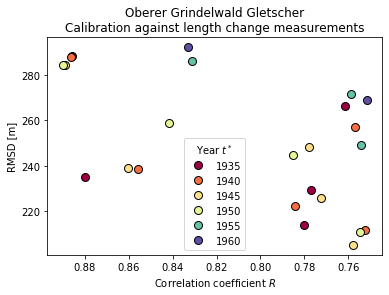

In [36]:
cmap = matplotlib.cm.get_cmap('Spectral', ds.t_star.size)
for i, t_star in enumerate(ds.t_star.values):
    x = ds_select.corr.sel(t_star=t_star)
    y = ds_select.rmsd.sel(t_star=t_star)
    plt.plot(x,y, ls='None', marker='o', color=cmap(i),
             markeredgecolor='k', markersize=8, label=t_star)
    
# get figure axes
ax = plt.gca()
ax.invert_xaxis()
# legend
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[::4], ds.t_star.values, title='Year $t^*$', loc=8)
# labels, title
ax.set_xlabel('Correlation coefficient $R$')
ax.set_ylabel('RMSD [m]')
ax.set_title('Oberer Grindelwald Gletscher\n' + 'Calibration against length change measurements');

In [38]:
# get corresponding supset from DataFrame
ds.where(ds_select.rmsd == ds_select.rmsd.min(), drop=True)

<xarray.Dataset>
Dimensions:     (glen_a_fac: 1, prcp_fac: 1, t_star: 1)
Coordinates:
  * glen_a_fac  (glen_a_fac) float64 1.0
  * t_star      (t_star) int64 1945
  * prcp_fac    (prcp_fac) float64 1.75
Data variables:
    corr        (glen_a_fac, prcp_fac, t_star) float64 0.7578
    rmsd        (glen_a_fac, prcp_fac, t_star) float64 205.2
    rmsd_bc     (glen_a_fac, prcp_fac, t_star) float64 196.7
    amp_diff    (glen_a_fac, prcp_fac, t_star) float64 834.4

There is one data points with a quite high correlation (.88) and a quite low RMSD (> 240 m). Let's take a closer look...

In [39]:
# define threshold
corr_threshold = 0.87
rmsd_threshold = 240

In [40]:
ds_select = ds.where((ds.corr > corr_threshold) & (ds.rmsd < rmsd_threshold), drop=False)

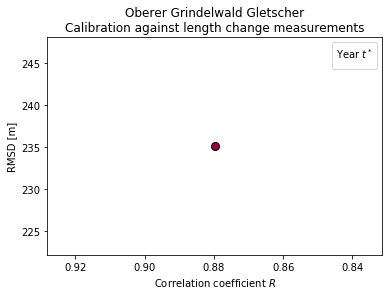

In [41]:
cmap = matplotlib.cm.get_cmap('Spectral', ds.t_star.size)
for i, t_star in enumerate(ds.t_star.values):
    x = ds_select.corr.sel(t_star=t_star)
    y = ds_select.rmsd.sel(t_star=t_star)
    plt.plot(x,y, ls='None', marker='o', color=cmap(i),
             markeredgecolor='k', markersize=8)
    
# get figure axes
ax = plt.gca()
ax.invert_xaxis()
# legend
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[::4], ds.t_star.values, title='Year $t^*$', loc=0)
# labels, title
ax.set_xlabel('Correlation coefficient $R$')
ax.set_ylabel('RMSD [m]')
ax.set_title('Oberer Grindelwald Gletscher\n' + 'Calibration against length change measurements');

In [42]:
# get corresponding supset from DataFrame
ds_select = ds.where((ds.corr > corr_threshold) & (ds.rmsd < rmsd_threshold), drop=True)
ds_select

<xarray.Dataset>
Dimensions:     (glen_a_fac: 1, prcp_fac: 1, t_star: 1)
Coordinates:
  * t_star      (t_star) int64 1935
  * prcp_fac    (prcp_fac) float64 1.75
  * glen_a_fac  (glen_a_fac) float64 2.0
Data variables:
    corr        (glen_a_fac, prcp_fac, t_star) float64 0.8798
    rmsd        (glen_a_fac, prcp_fac, t_star) float64 235.1
    rmsd_bc     (glen_a_fac, prcp_fac, t_star) float64 205.8
    amp_diff    (glen_a_fac, prcp_fac, t_star) float64 938.4

Let's use those parameters for the model run and look at the modeled glacier length.

In [43]:
# define parameters
t_star = 1935
bias = 0
prcp_fac = 1.75
glen_a_fac = 2.0

In [44]:
import oggm
from oggm import cfg, utils
from oggm.core import gis, centerlines, climate, massbalance, inversion, flowline

In [45]:
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/tmp_wdir/'
cfg.PATHS['working_dir'] = wdir

# set border high enough for idealized experiment
cfg.PARAMS['border'] = 20

# using intersects
cfg.PARAMS['use_intersects'] = True

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = prcp_fac
cfg.PARAMS['temp_melt'] = -1.75

## Preprocessing
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = utils.get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]

# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

# ### GIS
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)

# ### Centerlines
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

## Climate and mass balance parameters
# process the HistAlp climate file
climate.process_histalp_data(gdir)
climate.local_t_star(gdir, tstar=t_star, bias=bias)
climate.mu_star_calibration(gdir)

## Mass balance
# instance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

# store default values for Glen's A parameter
inv_glen_a = cfg.PARAMS['inversion_glen_a']
glen_a = cfg.PARAMS['glen_a']

# Change the creep parameter
cfg.PARAMS['inversion_glen_a'] = inv_glen_a * glen_a_fac
cfg.PARAMS['glen_a'] = glen_a * glen_a_fac

## Inversion
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

## Dynamic model
# finalize the preprocessing
flowline.init_present_time_glacier(gdir)

## Model
# read needed file
ci = gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model,
                                y0=ci['baseline_hydro_yr_0'])

# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(2014)

2019-10-24 12:24:02: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-10-24 12:24:03: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-10-24 12:24:03: oggm.core.gis: (RGI60-11.01270) glacier_masks
2019-10-24 12:24:04: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-10-24 12:24:04: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-10-24 12:24:04: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-10-24 12:24:04: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-10-24 12:24:04: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-10-24 12:24:06: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-10-24 12:24:07: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-10-24 12:24:08: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction
2019-10-24 12:24:08: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-10-24 1

Text(0.65, 0.05, '$t^*$: 1935\n$f_{prcp}$: 1.75\n$f_{Glens\\ A}$: 2.0')

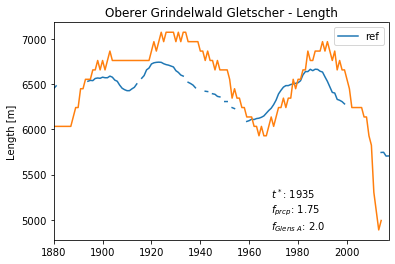

In [46]:
# first look at length
lengt_ref = pd.read_csv('/Users/oberrauch/work/grindelwald/data/length_ref_abs.csv', index_col=0)
lengt_ref.plot(legend=False)
diag_ds.length_m.plot()

# make plot fancier
ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('Length [m]')
ax.set_title('Oberer Grindelwald Gletscher - Length')
handels, _ = ax.get_legend_handles_labels()
ax.legend(handels, ['ref', 'oggm'])
# add parameters as text
ax.text(0.65, 0.05,
        '$t^*$: {}\n$f_{{prcp}}$: {}\n$f_{{Glens\ A}}$: {}'.format(t_star, prcp_fac, glen_a_fac),
        transform=ax.transAxes)

## Try to quantify the influence of the different tuning parameters
What follows are some statistical/graphic analysis, (unsuccessfully) performed to get a better understanding of which parameter causes which change... 

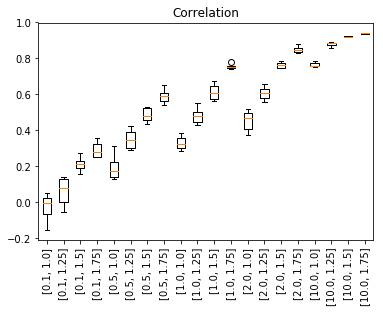

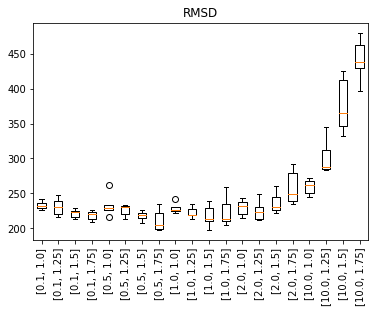

In [107]:
# create empty containers for indeces, correlation and rmsd
idx = list()
corr = list()
rmsd = list()

# iterate over all creep parameters scaling factors
for glen_a_fac in ds.glen_a_fac:
    # iterate over all precipitation scaling factors
    for prcp_fac in ds.prcp_fac:
        # select dataarray for given parameters
        ds_sel = ds.sel(glen_a_fac=glen_a_fac, prcp_fac=prcp_fac)
        # add values to container
        idx.append([float(glen_a_fac.values), float(prcp_fac.values)])
        corr.append(ds_sel['corr'])
        rmsd.append(ds_sel['rmsd'])
        
# plot
plt.boxplot(corr)
plt.title('Correlation')
plt.gca().set_xticklabels(labels=idx, rotation=90);

plt.figure()
plt.boxplot(rmsd)
plt.title('RMSD')
plt.gca().set_xticklabels(labels=idx, rotation=90);

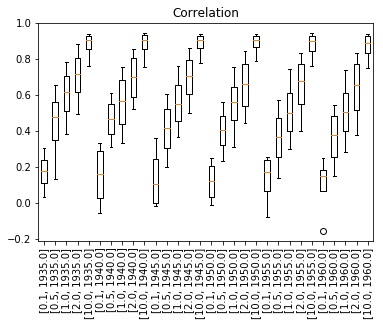

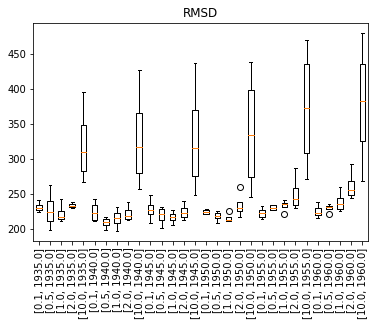

In [110]:
# create empty containers for indeces, correlation and rmsd
idx = list()
corr = list()
rmsd = list()

# iterate over all equilibrium years
for t_star in ds.t_star:
    # iterate over all creep parameters scaling factors
    for glen_a_fac in ds.glen_a_fac:
        # select dataarray for given parameters
        ds_sel = ds.sel(glen_a_fac=glen_a_fac, t_star=t_star)
        # add values to container
        idx.append([float(glen_a_fac.values), float(t_star.values)])
        corr.append(ds_sel['corr'])
        rmsd.append(ds_sel['rmsd'])
        
# plot
plt.boxplot(corr)
plt.title('Correlation')
plt.gca().set_xticklabels(labels=idx, rotation=90);

plt.figure()
plt.boxplot(rmsd)
plt.title('RMSD')
plt.gca().set_xticklabels(labels=idx, rotation=90);

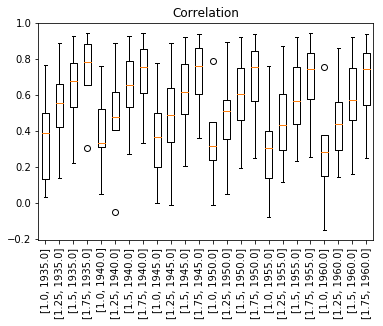

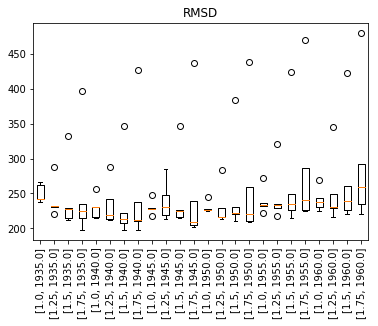

In [111]:
# create empty containers for indeces, correlation and rmsd
idx = list()
corr = list()
rmsd = list()

# iterate over all equilibrium years
for t_star in ds.t_star:
    # iterate over all precipitation scaling factors
    for prcp_fac in ds.prcp_fac:
        # select dataarray for given parameters
        ds_sel = ds.sel(prcp_fac=prcp_fac, t_star=t_star)
        # add values to container
        idx.append([float(prcp_fac.values), float(t_star.values)])
        corr.append(ds_sel['corr'])
        rmsd.append(ds_sel['rmsd'])
        
# plot
plt.boxplot(corr)
plt.title('Correlation')
plt.gca().set_xticklabels(labels=idx, rotation=90);

plt.figure()
plt.boxplot(rmsd)
plt.title('RMSD')
plt.gca().set_xticklabels(labels=idx, rotation=90);

**Some more plots**

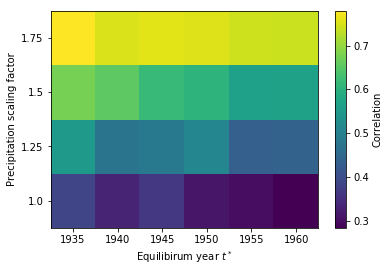

In [47]:
tmp = ds['corr'].sel({'glen_a_fac': 1})
plt.pcolormesh(tmp)
plt.xticks(np.arange(0.5, 6))
plt.gca().set_xticklabels(tmp.t_star.values)
plt.xlabel('Equilibirum year $t^*$')
plt.yticks(np.arange(0.5, 4))
plt.gca().set_yticklabels(tmp.prcp_fac.values)
plt.ylabel('Precipitation scaling factor')
plt.colorbar(label='Correlation')

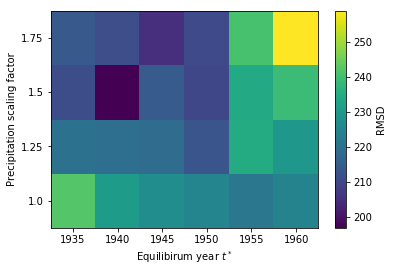

In [48]:
tmp = ds['rmsd'].sel({'glen_a_fac': 1})
plt.pcolormesh(tmp)
plt.xticks(np.arange(0.5, 6))
plt.gca().set_xticklabels(tmp.t_star.values)
plt.xlabel('Equilibirum year $t^*$')
plt.yticks(np.arange(0.5, 4))
plt.gca().set_yticklabels(tmp.prcp_fac.values)
plt.ylabel('Precipitation scaling factor')
plt.colorbar(label='RMSD')

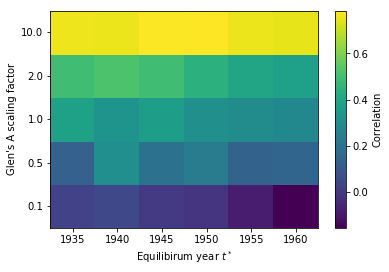

In [42]:
tmp = ds['corr'].sel({'prcp_fac': 1})
plt.pcolormesh(tmp)
plt.xticks(np.arange(0.5, 6))
plt.gca().set_xticklabels(tmp.t_star.values)
plt.xlabel('Equilibirum year $t^*$')
plt.yticks(np.arange(0.5, 5))
plt.gca().set_yticklabels(tmp.glen_a_fac.values)
plt.ylabel("Glen's A scaling factor")
plt.colorbar(label='Correlation')

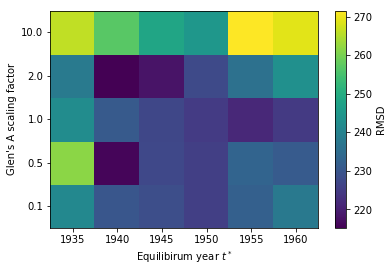

In [43]:
tmp = ds['rmsd'].sel({'prcp_fac': 1})
plt.pcolormesh(tmp)
plt.xticks(np.arange(0.5, 6))
plt.gca().set_xticklabels(tmp.t_star.values)
plt.xlabel('Equilibirum year $t^*$')
plt.yticks(np.arange(0.5, 5))
plt.gca().set_yticklabels(tmp.glen_a_fac.values)
plt.ylabel("Glen's A scaling factor")
plt.colorbar(label='RMSD')

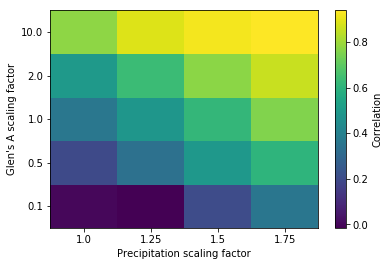

In [30]:
tmp = ds['corr'].sel({'t_star': 1945})
plt.pcolormesh(tmp)
plt.xticks(np.arange(0.5, 4))
plt.gca().set_xticklabels(tmp.prcp_fac.values)
plt.xlabel('Precipitation scaling factor')
plt.yticks(np.arange(0.5, 5))
plt.gca().set_yticklabels(tmp.glen_a_fac.values)
plt.ylabel("Glen's A scaling factor")
plt.colorbar(label='Correlation')

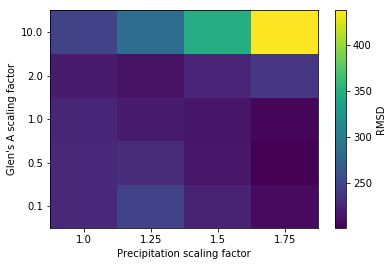

In [36]:
tmp = ds['rmsd'].sel({'t_star': 1945})
plt.pcolormesh(tmp)
plt.xticks(np.arange(0.5, 4))
plt.gca().set_xticklabels(tmp.prcp_fac.values)
plt.xlabel('Precipitation scaling factor')
plt.yticks(np.arange(0.5, 5))
plt.gca().set_yticklabels(tmp.glen_a_fac.values)
plt.ylabel("Glen's A scaling factor")
plt.colorbar(label='RMSD')